<a href="https://colab.research.google.com/github/enlupi/SNN-MUC/blob/main/Scripts/DTFastSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Simulation


In [1]:
import random as rnd
import numpy as np
import math
import string
from scipy.stats import binom

import tqdm

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate

from snntorch import spikegen

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Muon Chamber Settings



In [2]:
DURATION = {
    'orbit:bx': 3564,
    'orbit': 3564*25,
    'bx': 25.,
    'tdc': 25./30
}

XCELL = 42. # cell width in mm
ZCELL = 13. # cell height in mm

TDRIFT = 15.6*DURATION['bx']  # drift time in ns
VDRIFT = XCELL*0.5 / TDRIFT   # drift velocity in mm/ns

## number of cells
NLAYERS = 8 # number of layers
NWIRES  = 8 # numbers of cells per layer
# Starting from a single cell, new columns are added alternating on the right and on the left,
# while new rows are added alternating on the bottom and on the top

## shifts
pos_shift_z  = [ZCELL*(-(NLAYERS-1-(NLAYERS%2))/2 + i) for i in range(NLAYERS)] # [..., -1.5*ZCELL, -0.5*ZCELL, 0.5*ZCELL, 1.5*ZCELL, ...]
                                                                                # If NLAYERS is odd, the additional layer in on top
is_shifted_right = [(i+1+(NLAYERS//2)%2)%2 for i in range(NLAYERS)]             # 1 if layer is shifted to the right, 0 otherwise
                                                                                # For NLAYERS=4 it is [1, 0, 1, 0]

# mappings

WIRE_MAP = {i:string.ascii_uppercase[i-1] for i in range(1, NWIRES+1)}
SIDE_MAP = {-1:'L',1:'R'}

LAYER_MAP = [-99] + [i-1 for i in range(NLAYERS, 0, -1)]

## Generate Signal Events

In [3]:
def correct_hit(psi, dx):
    ## corrections
    slope = 4
    offset = 6#4
    linear_factor = 15

    # region near the wire
    x0 = (offset+linear_factor*math.pow(math.tan(psi),1.5)) / slope

    if dx<=x0:
        # linear relation
        return offset+linear_factor*math.pow(math.tan(psi),1.5) - slope*dx
    else:
        return  0#-5*math.tan(psi)*np.sin(math.tan(psi)*4*math.pi/15*(dx-x0))

In [4]:
def generate_muon(bx0, useIdealEF=False):

    tdc0 = np.random.randint(0,30)
    angle = rnd.uniform(math.pi*1./4., math.pi*3./4.)

    m = math.tan(angle)
    xmin = -(1+(NWIRES-1)//2)*XCELL
    xmax = (0.5+NWIRES//2)*XCELL
    entry_point = rnd.uniform(xmin, xmax)
    q = - m*entry_point

    psi = math.pi/2-angle

    muon_hits = []

    wire_pattern = ''
    side_pattern = ''

    for l in range(NLAYERS):
        x = (pos_shift_z[l] - q)/m

        # apply smearing
        x += 0.25*np.random.randn()

        # find the wire
        nw = math.floor((x-xmin-is_shifted_right[l]*0.5*XCELL)/XCELL)+1

        # remove hits outside the macrocell
        if nw < 1 or nw > NWIRES: continue

        # find the distance from the wire
        dx = x - xmin - (is_shifted_right[l]+1)*0.5*XCELL - (nw-1)*XCELL

        # remove hits in the I
        if abs(dx) >= (21 - 1.4/2):
            continue

        ## apply EF dishomogeneity
        # drift time
        t = abs(dx) / VDRIFT

        if not useIdealEF:
            t -= 19.79*math.pow(math.tan(psi),2)
            t += correct_hit(abs(psi), abs(dx))

        # compute BX and TDC
        bx = t // DURATION['bx']
        dt = t % DURATION['bx']


        tdc_meas = (int(np.floor(dt/DURATION['tdc'])) + tdc0) % 30
        bx_counter = int(bx0 + bx) + (int(np.floor(dt/DURATION['tdc'])) + tdc0)//30

        wire_pattern += f"{l+1}{WIRE_MAP[nw]}"
        side_pattern += f"{SIDE_MAP[1 if dx>0 else -1]}"

        muon_hits.append({
            'layer': l + 1,
            'wire_num': nw,
            'bx': bx_counter,
            'tdc': tdc_meas,
            'label': 1 if dx>0 else -1,
            't0': bx0+tdc0/30,
            'psi': psi,
            'x0': entry_point,
        })

    # get expected eq label
    """ wire_pos, side = wire_pattern, side_pattern
    wire_nums = [int(wire_pos[i])-1 for i in range(0,len(wire_pos),2)]

    if (side[:3] in ['LLL', 'RRR']) and (len(side)==4):
        wire_pos = wire_pos[2:]
        side = side[1:]
    else:
        wire_pos = wire_pos[:6]
        side = side[:3]

    selected_pattern = f'{wire_pos}-{side}'
    eq_label = find_label_from_pattern(selected_pattern)"""

    return muon_hits, f'{wire_pattern}-{side_pattern}' #,eq_label

In [5]:
def get_event(bx0):
    valid_event_flag = False
    num_muon_hits = 0
    while not valid_event_flag:
        muon_hits, gen_pattern = generate_muon(bx0)
        if len(muon_hits) >= (NLAYERS-1):
            lat = gen_pattern.split('-')[1]
            if lat.find('LLL') == -1 and lat.find('RRR') == -1:
                valid_event_flag = True
                num_muon_hits = len(muon_hits)

    # add noise
    num_hits = len(muon_hits)

    # signal label
    signal_type = True

    return muon_hits, gen_pattern, num_muon_hits, num_hits, signal_type

In [6]:
# generate a single event at BX0=500
muon_hits, pattern, num_muon_hits, num_hits, signal = get_event(500)

print(muon_hits)
print(pattern)

[{'layer': 1, 'wire_num': 3, 'bx': 501, 'tdc': 26, 'label': -1, 't0': 500.93333333333334, 'psi': 0.2170814676260382, 'x0': -32.65363982212358}, {'layer': 2, 'wire_num': 4, 'bx': 514, 'tdc': 16, 'label': -1, 't0': 500.93333333333334, 'psi': 0.2170814676260382, 'x0': -32.65363982212358}, {'layer': 3, 'wire_num': 3, 'bx': 504, 'tdc': 21, 'label': 1, 't0': 500.93333333333334, 'psi': 0.2170814676260382, 'x0': -32.65363982212358}, {'layer': 4, 'wire_num': 4, 'bx': 510, 'tdc': 5, 'label': -1, 't0': 500.93333333333334, 'psi': 0.2170814676260382, 'x0': -32.65363982212358}, {'layer': 5, 'wire_num': 3, 'bx': 508, 'tdc': 25, 'label': 1, 't0': 500.93333333333334, 'psi': 0.2170814676260382, 'x0': -32.65363982212358}, {'layer': 6, 'wire_num': 4, 'bx': 506, 'tdc': 22, 'label': -1, 't0': 500.93333333333334, 'psi': 0.2170814676260382, 'x0': -32.65363982212358}, {'layer': 7, 'wire_num': 3, 'bx': 513, 'tdc': 7, 'label': 1, 't0': 500.93333333333334, 'psi': 0.2170814676260382, 'x0': -32.65363982212358}, {'l

### Event Data Type

In [7]:
## event data structure
# ev_id
# MC (4x4):
#  - hit (bx, tdc, label)
# t0
# angle
# x0
# n_true_hits
# n_hits
# pattern

hit_dtype = np.dtype([
    ('bx', np.int16),
    ('tdc', np.int16),
    ('label', np.int8)
])

gen_event_dtype = np.dtype([
    ('id', np.int16),
    ('mc', hit_dtype, (NLAYERS,NWIRES)),
    ('t0', np.float32),
    ('angle', np.float16),
    ('x0', np.float16),
    ('n_true_hits', np.int8),
    ('n_hits', np.int8),
    ('signal', np.bool_)
])

In [8]:
# fill event structure
def hits_to_numpy(event, muon_hits, signal_type):
    for hit in muon_hits:
        layer, wire = hit['layer']-1, hit['wire_num']-1

        curr_mc = event['mc'][::-1]
        curr_mc['bx'][layer, wire] = hit['bx']
        curr_mc['tdc'][layer, wire] = hit['tdc']
        curr_mc['label'][layer, wire] = hit['label']

    event['t0'] = muon_hits[0]['t0']
    event['angle'] = muon_hits[0]['psi']
    event['x0'] = muon_hits[0]['x0']

    event['n_hits'] = np.count_nonzero(event['mc']['bx']!=-1)
    event['n_true_hits'] = np.count_nonzero(event['mc']['label']!=0)
    event['signal'] = signal_type

def numpy_to_hits(event):
    muon_hits = []

    # find hits in macrocell
    curr_mc = event['mc'][::-1]

    hits_idx = np.where(curr_mc['bx']!=-1)
    for l, w in zip(*hits_idx):
        muon_hits.append({
            'layer': l+1,
            'wire_num': w+1,
            'bx': curr_mc['bx'][l, w],
            'tdc': curr_mc['tdc'][l, w],
            'label': curr_mc['label'][l,w],
            't0': event['t0'],
            'psi': event['angle'],
            'x0': event['x0']
        })

    return muon_hits

In [9]:
#num_events = 20000

#events_arr_no_noise = np.zeros(num_events, dtype=gen_event_dtype)
#events_arr_no_noise['mc']['bx'] = -1
#events_arr_no_noise['mc']['tdc'] = -1

#for ev_id in tqdm.tqdm(range(num_events)):
#    muon_hits, pattern, num_muon_hits, num_hits, signal = get_event(500)

#    events_arr_no_noise[ev_id]['id'] = ev_id
#    hits_to_numpy(events_arr_no_noise[ev_id], muon_hits, signal)

## Generate Noise


In [10]:
bx0 = 500
bx_oot = 10
noise_distributions = np.concatenate([
    np.random.triangular(bx0-bx_oot, bx0, bx0,10000),
    np.random.uniform(bx0,bx0+16,30000),
    np.random.triangular(bx0+16,bx0+16,bx0+16+bx_oot,10000)
])
cell_ineff = 0.06

def get_event_noise(bx0, noise_frac=0, bkg_frac=0.2):
    # simulate true event
    if np.random.rand() <= (1 - bkg_frac):
        valid_event_flag = False
        num_muon_hits = 0
        while not valid_event_flag:
            muon_hits, gen_pattern = generate_muon(bx0)
            if len(muon_hits) >= (NLAYERS-1):
                lat = gen_pattern.split('-')[1]
                if lat.find('LLL') == -1 and lat.find('RRR') == -1:
                    valid_event_flag = True
                    num_muon_hits = len(muon_hits)

        # simulate cell inefficiency
        dead_cells = binom.rvs(num_muon_hits, cell_ineff) #if (num_muon_hits==NLAYERS) and (np.random.rand()<=0.2):
        for i in range(dead_cells):
            # remove one hit
            _ = muon_hits.pop(np.random.randint(len(muon_hits)))

        # add noise
        if np.random.rand()<noise_frac:
            # number of noise hits
            n_noise = np.random.choice([1,2,3,4], p=[0.45,0.3,0.2,0.05])
            t0 = muon_hits[0]['t0']
            angle = muon_hits[0]['psi']
            x0 = muon_hits[0]['x0']
            for _ in range(n_noise):
                layer,wire_num = np.random.randint(1,NLAYERS+1), np.random.randint(1,NWIRES+1)
                #bx = bx0+np.random.randint(-10,20)
                bx = round(np.random.choice(noise_distributions, 1)[0])
                tdc = np.random.randint(0,31)
                label = 0
                # check if it can be a real hit..
                """if bx>bx0:
                    #tdrift = (bx-bx0+tdc/30)*25
                    tdrift = (bx+tdc/30-t0)*25
                    if tdrift<TDRIFT-10:
                        dx = tdrift*VDRIFT
                        wire_pos = pos_shift_x[layer-1] + (wire_num-1)*XCELL
                        x_l = wire_pos - dx
                        x_r = wire_pos + dx

                        x_th = math.tan(angle)*pos_shift_z[layer-1]+x0

                        res_l, res_r = abs(x_l-x_th), abs(x_r-x_th)

                        if (res_l <= res_r) and (res_l<=1):
                            label = -1
                        elif (res_l >= res_r) and (res_r<=1):
                            label = +1
                        else:
                            label = 0"""

                muon_hits.append({
                        'layer': layer,
                        'wire_num': wire_num,
                        'bx': bx,
                        'tdc': tdc,
                        'label': label,
                        't0': t0,
                        'psi': angle,
                        'x0': x0
                    })

        # signal label
        signal_type = True

    # simulate noise
    else:
        muon_hits = []
        num_muon_hits = 0
        n_noise = np.random.choice([1,2,3,4], p=[0.45,0.40,0.1,0.05])
        for _ in range(n_noise):
            layer,wire_num = np.random.randint(1,NLAYERS+1), np.random.randint(1,NWIRES+1)
            t0 = bx0
            angle = -9
            x0 = -9
            bx = round(np.random.choice(noise_distributions, 1)[0])
            tdc = np.random.randint(0,31)
            label = 0
            gen_pattern = ''
            muon_hits.append({
                'layer': layer,
                'wire_num': wire_num,
                'bx': bx,
                'tdc': tdc,
                'label': label,
                't0': t0,
                'psi': angle,
                'x0': x0
            })

        # signal label
        signal_type = False

    # shuffle list
    rnd.shuffle(muon_hits)

    num_hits = len(muon_hits)

    return muon_hits, gen_pattern, num_muon_hits, num_hits, signal_type

In [11]:
## generate noisy events

num_events = 30000
num_events_test = 5000

def generate_noisy_evts(num_events, bx0=500, noise_frac=0.1, bkg_frac=0.5):
    events_arr = np.zeros(num_events, dtype=gen_event_dtype)
    # initialize array
    events_arr['mc']['bx'] = -1
    events_arr['mc']['tdc'] = -1

    for ev_id in tqdm.tqdm(range(num_events)):
        muon_hits, pattern, num_muon_hits, num_hits, signal = get_event_noise(bx0, noise_frac, bkg_frac)

        events_arr[ev_id]['id'] = ev_id
        hits_to_numpy(events_arr[ev_id], muon_hits, signal)

    return events_arr

events_arr = generate_noisy_evts(num_events, bkg_frac=0.2)
events_arr_test = generate_noisy_evts(num_events_test, bkg_frac=0.2)

100%|██████████████████████████████████████████| 5000/5000 [00:01<00:00, 4317.45it/s]


## Plot Results

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams.update({'figure.max_open_warning': 0})


DURATION = {
    'orbit:bx': 3564,
    'orbit': 3564*25,
    'bx': 25.,
    'tdc': 25./30
}

#NLAYERS = 4
#NWIRES  = 4

XCELL = 42. # cell width in mm
ZCELL = 13. # cell height in mm

WIRE_DIAM     = 0.050 # in mm
PLANE_WIDTH   = 1.5 # in mm
IBEAM_WIDTH   = 1.3  # in mm FROM https://github.com/cms-sw/cmssw/blob/master/Geometry/DTGeometry/src/DTTopology.cc
IBEAM_WING    = 6.35  # in mm FROM https://github.com/cms-sw/cmssw/blob/master/Geometry/DTGeometry/src/DTTopology.cc

TM        = 15.5
TDRIFT    = TM*DURATION['bx']  # drift time in ns
VDRIFT    = XCELL*0.5 / TDRIFT   # drift velocity in mm/ns
VDRIFTMMBX= XCELL*0.5 / TM       # drift velocity in mm/BX
VHRATIO   = XCELL*0.5/TM/ZCELL


pos_z = [ np.nan ] + [ZCELL*(-(NLAYERS-1-(NLAYERS%2))/2 + i) for i in range(NLAYERS)]
xmin = -(1+(NWIRES-1)//2)*XCELL
pos_x = [ np.nan ] + [xmin + (1+s)*0.5*XCELL for s in is_shifted_right]


def plot_muon(muon_hits, bx0, x0=None, m=None, t0_scint=None, save_me=False):
    """
    Plot a list of muon hits
    Args:
        - muon_hits: list of dicts containing at least the following
                     information:
                        - hit layer
                        - hit wire (in the macrocell)
                        - hit bx
                        - hit tdc
                        - hit side (-1,0,1)
        - bx0: time pedestal for this macrocell
        - x0: local intercept of the track
        - m: tan_psi of the track
    """

    fig, ax = plt.subplots(1, 1, figsize=(XCELL*(NWIRES+1)/10,NLAYERS*ZCELL/10))

    def the_grid(the_plot):
        for ilay in range(1, NLAYERS+1):
            for iwire in range(1, NWIRES+1):
                the_plot.plot(pos_x[ilay]+XCELL*(iwire-1),pos_z[ilay],
                              marker='.',
                              markersize=2,
                              color='grey',
                              zorder=-10)
                the_plot.add_patch(
                    Rectangle((pos_x[ilay]-0.5*XCELL+XCELL*(iwire-1),
                                   pos_z[ilay]-ZCELL*0.5),
                                  XCELL,
                                  ZCELL,
                                 edgecolor='lightgrey',
                                 facecolor='None',
                             zorder=-10)
                )

    def the_planes(the_plot):
        for ilay in  range(1, NLAYERS+1):
            the_plot.add_patch(
                Rectangle((pos_x[ilay]-0.5*XCELL,
                           pos_z[ilay]-ZCELL*0.5-PLANE_WIDTH/2.),
                          NWIRES*XCELL,
                          PLANE_WIDTH,
                          facecolor='darkgrey',
                          edgecolor='None',
                          zorder=-15)
            )
            the_plot.add_patch(
                Rectangle((pos_x[ilay]-0.5*XCELL,
                           ZCELL+pos_z[ilay]-ZCELL*0.5-PLANE_WIDTH/2.),
                          NWIRES*XCELL,
                          PLANE_WIDTH,
                          facecolor='darkgrey',
                          edgecolor='None',
                          zorder=-15)
            )


    def the_ibeams(the_plot):
        for ilay in  range(1, NLAYERS+1):
            for iwire in range(1, NWIRES+1):
                the_plot.add_patch(
                    Rectangle((pos_x[ilay]-0.5*XCELL+XCELL*(iwire-1)-IBEAM_WIDTH/2,
                               pos_z[ilay]-ZCELL*0.5-PLANE_WIDTH/2.),
                              IBEAM_WIDTH,
                              ZCELL+PLANE_WIDTH,
                              facecolor='darkgrey',
                              edgecolor='None',
                              zorder=-13)
                )
                the_plot.add_patch(
                    Rectangle((XCELL+pos_x[ilay]-0.5*XCELL+XCELL*(iwire-1)-IBEAM_WIDTH/2,
                               pos_z[ilay]-ZCELL*0.5-PLANE_WIDTH/2.),
                              IBEAM_WIDTH,
                              ZCELL+PLANE_WIDTH,
                              facecolor='darkgrey',
                              edgecolor='None',
                              zorder=-13)
                )

                the_plot.add_patch(
                    Rectangle((XCELL+pos_x[ilay]-0.5*XCELL+XCELL*(iwire-1)-IBEAM_WING/2,
                               pos_z[ilay]-ZCELL*0.5+PLANE_WIDTH/2.),
                              IBEAM_WING,
                              IBEAM_WIDTH,
                              facecolor='darkgrey',
                              edgecolor='None',
                              zorder=-13)
                )
                the_plot.add_patch(
                    Rectangle((XCELL+pos_x[ilay]-0.5*XCELL+XCELL*(iwire-1)-IBEAM_WING/2,
                                  pos_z[ilay]+ZCELL*0.5-PLANE_WIDTH/2.-IBEAM_WIDTH),
                                  IBEAM_WING,
                                  IBEAM_WIDTH,
                                  facecolor='darkgrey',
                                  edgecolor='None',
                             zorder=-13)
                )

                the_plot.add_patch(
                    Rectangle((XCELL+pos_x[ilay]-0.5*XCELL+XCELL*(iwire-2)-IBEAM_WING/2,
                                  pos_z[ilay]-ZCELL*0.5+PLANE_WIDTH/2.),
                                  IBEAM_WING,
                                  IBEAM_WIDTH,
                                  facecolor='darkgrey',
                                  edgecolor='None',
                             zorder=-13)
                )
                the_plot.add_patch(
                    Rectangle((XCELL+pos_x[ilay]-0.5*XCELL+XCELL*(iwire-2)-IBEAM_WING/2,
                                  pos_z[ilay]+ZCELL*0.5-PLANE_WIDTH/2.-IBEAM_WIDTH),
                                  IBEAM_WING,
                                  IBEAM_WIDTH,
                                  facecolor='darkgrey',
                                  edgecolor='None',
                             zorder=-13)
                )



    the_grid(ax)
    the_planes(ax)
    the_ibeams(ax)

    for hit in muon_hits:
        layer, wire, bx, tdc =  hit['layer'], hit['wire_num'], hit['bx'], hit['tdc']
        plt.scatter(pos_x[layer] + (wire-1)*XCELL, pos_z[layer], color='red')

        # x left and right
        wire_pos = pos_x[layer] + (wire-1)*XCELL
        wire_z   = pos_z[layer]

        tdrift = (bx + tdc/30 - bx0)*DURATION['bx']
        x_drift = tdrift * VDRIFT
        """print("z: {}".format(wire_z))
        print("x-: {}".format(wire_pos - x_drift))
        print("x+: {}".format(wire_pos + x_drift))"""
        plt.scatter(wire_pos - x_drift, wire_z, color='green', marker="x")
        plt.scatter(wire_pos + x_drift, wire_z, color='green', marker="x")

        if t0_scint != None:
            tdrift = (bx + tdc/30 - t0_scint)*DURATION['bx']
            x_drift = tdrift * VDRIFT
            plt.scatter(wire_pos - x_drift, wire_z,  s=80, facecolors='none', edgecolors='b')
            plt.scatter(wire_pos + x_drift, wire_z,  s=80, facecolors='none', edgecolors='b')


    if (x0!=None) and (m!=None):
        bottom_x = x0 + m*(pos_z[1]-0.5*ZCELL)
        top_x    = x0 + m*(pos_z[NLAYERS]+0.5*ZCELL)

        plt.plot((bottom_x,top_x),(pos_z[1]-0.5*ZCELL,pos_z[NLAYERS]+0.5*ZCELL),'b-')

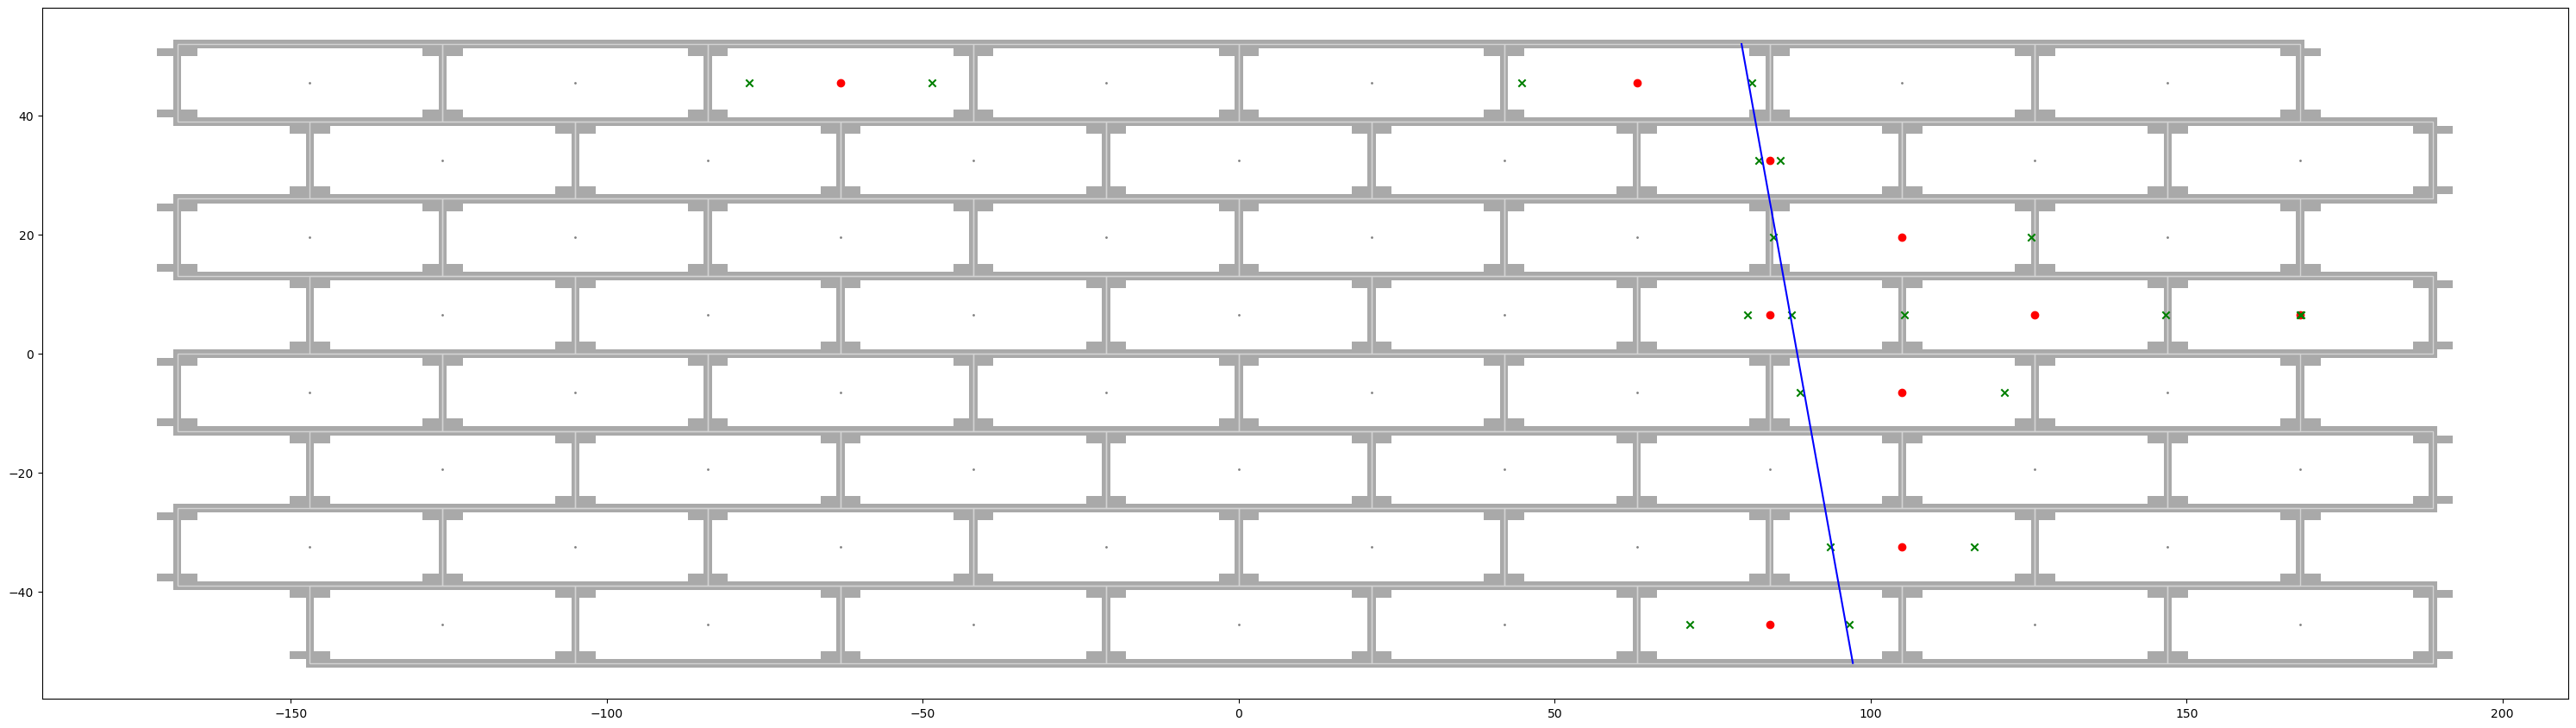

In [13]:
def plot_event(event):
    muon_hits = numpy_to_hits(event)
    m, x0 = np.tan(muon_hits[0]['psi']), muon_hits[0]['x0']
    plot_muon(muon_hits=muon_hits, bx0=500, m=m, x0=x0)

plot_event(events_arr[events_arr['n_hits']==10][0])

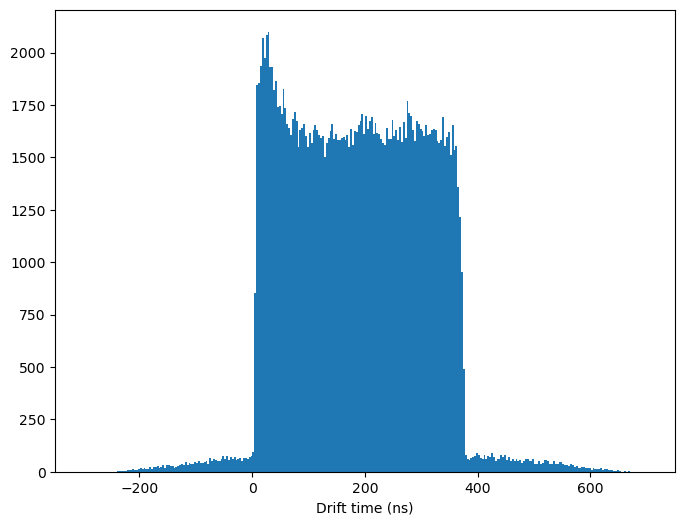

In [14]:
def get_timebox(nhits=[NLAYERS-1,NLAYERS]):
    curr_events = events_arr[np.isin(events_arr['n_true_hits'], nhits)]
    idxs = np.where((curr_events['mc']['bx']!=0))
    a = (curr_events['mc']['bx']+curr_events['mc']['tdc']/30)
    b = curr_events['t0']

    return (a-b[:,np.newaxis,np.newaxis])[idxs]*25

plt.figure(figsize=(8,6))
plt.hist(
    get_timebox([h for h in range(NLAYERS+1)]),
    bins=300, range=(-299.5,700.5),
    label = 'test'
)
#plt.legend()
plt.xlabel('Drift time (ns)')
plt.show()

# SNN

In [15]:
def event_to_matrix(event,rec=True):
    tmp_matrix = event['tdc']*(25/30)+event['bx']*25
    tmp_matrix[tmp_matrix <0] = 0
    
    min_value = np.min(tmp_matrix)
    max_value = np.max(tmp_matrix)
    
    tmp_matrix = (tmp_matrix - min_value) / (max_value - min_value)
    
    if rec:
        tmp_matrix[tmp_matrix > 0] = 1/tmp_matrix[tmp_matrix > 0]
        
        min_value = np.min(tmp_matrix)
        max_value = np.max(tmp_matrix)

        tmp_matrix = (tmp_matrix - min_value) / (max_value - min_value)
        
    return tmp_matrix

In [16]:
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(data, targets, epoch,counter, iter_counter, loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

### Create datasets - preprocessing

In [17]:
#train set
input_data_r=np.zeros((num_events,NLAYERS,NWIRES))
input_data_t=np.zeros((num_events,NLAYERS,NWIRES))

for i in range(num_events):
    input_data_r[i]=event_to_matrix(events_arr['mc'][i],True)
    input_data_t[i]=event_to_matrix(events_arr['mc'][i],False)
    
target_data = np.ones(num_events)
for i in range(num_events):
    if events_arr[i]['n_true_hits'] == 0:
        target_data[i] = 0
        
#test set
test_data_r=np.zeros((num_events_test,NLAYERS,NWIRES))

for i in range(num_events_test):
    test_data_r[i]=event_to_matrix(events_arr_test['mc'][i],True)
    
target_test = np.ones(num_events_test)
for i in range(num_events_test):
    if events_arr_test[i]['n_true_hits'] == 0:
        target_test[i] = 0

In [18]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target_data,transform=None):
        self.input_data = input_data
        self.target_data = target_data
        
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        
        input_sample = self.input_data[idx]
        target_sample = self.target_data[idx]
        
        if self.transform:
            input_sample = self.transform(input_sample)
            target_sample = int(target_sample)
            
        return input_sample, target_sample

def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    tensor = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = tensor.to(target_dtype)
    
    return tensor

# Define a transform for 4x4 matrices
transform = transforms.Compose([
    to_tensor_and_dtype
])

train_rate = CustomDataset(input_data_r,target_data, transform=transform)
test_rate = CustomDataset(test_data_r,target_test, transform=transform)

### SNN architecture

In [19]:
# Network Architecture
num_inputs = NLAYERS*NWIRES
num_hidden = 100
num_outputs = 2

# Temporal Dynamics
num_steps = 25
beta = 0.7

batch_size = 60

In [20]:
class Net(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad)
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x)
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
    
net = Net(64,100,2,25).to(device)

### SNN training

In [21]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

train_loader_rate = DataLoader(train_rate, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader_rate = DataLoader(test_rate, batch_size=batch_size, shuffle=False, num_workers=0)

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader_rate)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=torch.float, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader_rate))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=torch.float, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 17.07
Test Set Loss: 16.43
Train set accuracy for a single minibatch: 21.67%
Test set accuracy for a single minibatch: 18.33%


Epoch 0, Iteration 50
Train Set Loss: 7.44
Test Set Loss: 8.35
Train set accuracy for a single minibatch: 76.67%
Test set accuracy for a single minibatch: 66.67%


Epoch 0, Iteration 100
Train Set Loss: 5.34
Test Set Loss: 5.75
Train set accuracy for a single minibatch: 100.00%
Test set accuracy for a single minibatch: 98.33%


Epoch 0, Iteration 150
Train Set Loss: 5.92
Test Set Loss: 5.19
Train set accuracy for a single minibatch: 100.00%
Test set accuracy for a single minibatch: 98.33%


Epoch 0, Iteration 200
Train Set Loss: 3.68
Test Set Loss: 4.67
Train set accuracy for a single minibatch: 98.33%
Test set accuracy for a single minibatch: 98.33%


Epoch 0, Iteration 250
Train Set Loss: 4.67
Test Set Loss: 4.32
Train set accuracy for a single minibatch: 98.33%
Test set accuracy for a single minibatch: 98.33%


Epoch 0, 

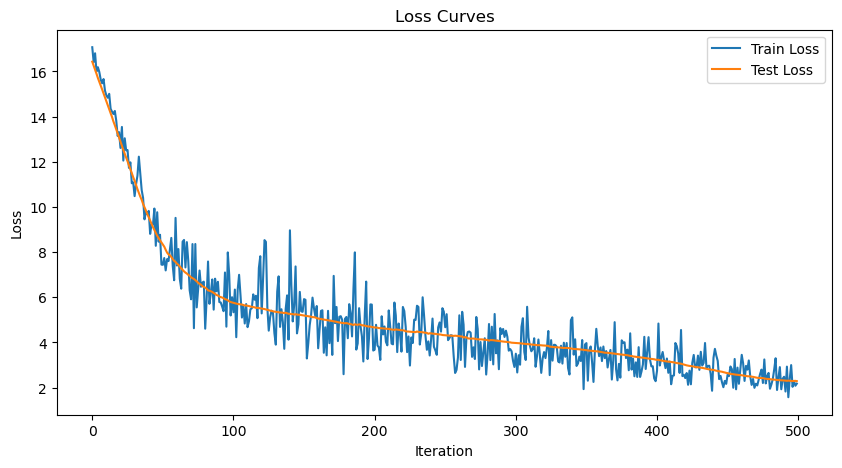

In [22]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [23]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(test_rate, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
    net.eval()
    
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
    
        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 4989/5000
Test Set Accuracy: 99.78%
